In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from src.data.importer import *
from src.data.processer import *
from src.events.main import sim_events, list_of_params
from src.probability.functions import ic_params_nsi,perform_chisq
from scipy.stats import chi2
from src.events.event_processing import *
import pickle
from multiprocessing import Pool
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

giunti_contour_cl90 = pd.read_csv('./src/data/files/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./src/data/files/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./src/data/files/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./src/data/files/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
ic_34_cl90 = pd.read_csv('./src/data/files/ic_34_cl90.csv',header=None, names=['s24','s34']).sort_values('s34')
ic_34_cl99 = pd.read_csv('./src/data/files/ic_34_cl99.csv',header=None, names=['s24','s34']).sort_values('s34')


In [2]:
ndim = 4
N = 13
alpha = 0.99
precomputed_events = True
gamma=0
ic_params_nsi['dm_41'] = 0.93
ic_params['dm_41'] = 0.93
emm_range = np.linspace(-1e-2,1e-2,10)
s24_range = np.logspace(-2,np.log10(0.2),10)
emt_range = np.linspace(-1e-2,1e-2,10)
param_list = list_of_params_nsi(ic_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)


'''
param_list = return_precomputed_nsi(N,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)
'''

"\nparam_list = return_precomputed_nsi(N,ndim,params=param_list)\nemm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))\ns24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2\nemt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))\n\nprint(emm_range)\nprint(s24_range)\nprint(emt_range)\n"

In [3]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    p = Pool()
    data = [(alpha, N,p, False,False, [False, np.median(Ereco), gamma],True, True) for p in param_list]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    if len(emt_range) > 1:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','wb'))
    else:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','wb'))

    H0_events = sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[False, np.median(Ereco), gamma],tau=True, nsi=True)
    pickle.dump(H0_events,open(f'./pre_computed/H0_N{N}_nsi_emt.p','wb'))
'''
if len(emt_range) > 1:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','rb'))
else:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))

'''
H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi_multi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))

gamma = 0.3
delta_T = (np.sum(sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma],tau=True, nsi=True)) - np.sum(H0_events))/np.sum(H0_events)

H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,z_bins)

In [5]:
sigma_a = 0.25
sigma_b = 0.04
f = 0.1
deltachi, best_index, H1_chisq,H0_chisq = get_deltachi(H1_list_normalized, H0_normalized,emm_range,s24_range,delta_T,[sigma_a,sigma_b],f,x0=[1],emt_range=emt_range)
#s24_cl90, s24_cl99, emm_cl90, emm_cl99 = get_contour(deltachi.reshape(len(emm_range),len(s24_range)).T, emm_range,s24_range)
#best_fit_coords = (np.sin(2*param_list[best_index]['theta_24'])**2, param_list[best_index]['e_mm'])

In [13]:
np.unravel_index(np.argmin(deltachi.T),deltachi.shape)

(0, 9, 4)

In [16]:
deltachi.T < 

array([[[ 1.0694013 ,  0.49089254,  0.21351675,  0.09739735,  0.06206502,  0.06751369,  0.12087893,  0.2822205 ,  0.66783548,  1.42039993],
        [ 1.05950352,  0.4814357 ,  0.20484218,  0.08968998,  0.05493357,  0.05996919,  0.1131512 ,  0.27352485,  0.6579916 ,  1.40987508],
        [ 1.04863339,  0.4717595 ,  0.19645648,  0.08225759,  0.04786087,  0.0529421 ,  0.10491442,  0.26473307,  0.6474663 ,  1.39813568],
        [ 1.0371601 ,  0.46225994,  0.18743498,  0.07478681,  0.04049816,  0.04546955,  0.09731791,  0.25558147,  0.63724825,  1.38626951],
        [ 1.02526871,  0.4522235 ,  0.17946863,  0.06755711,  0.03373043,  0.03852537,  0.0893005 ,  0.24664605,  0.62691193,  1.37393864],
        [ 1.01430241,  0.44271287,  0.17101828,  0.06030927,  0.02662734,  0.03126834,  0.0816147 ,  0.23762223,  0.61678506,  1.36026143],
        [ 1.00187071,  0.43268098,  0.16265495,  0.05252362,  0.01982097,  0.02401776,  0.07359964,  0.22869563,  0.60556349,  1.34739864],
        [ 0.98966307

In [41]:
emt_cl90, emt_cl99, emm_cl90, emm_cl99= get_contour(deltachi.T[4], emm_range,emt_range)

In [32]:
cont = np.where(deltachi.T[4] < chi2.ppf(q = 0.90,df=3),1,0)
cont

array([[0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [34]:
cont[0,:]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [38]:
cont[0,1]

1

In [36]:
array = []
for i in range(9):
    for j in range(9):
        if cont[i,j] - cont[i,j+1] != 0:
            array.append(j)
            
array


[0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 8, 0, 8, 0, 8]

Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.04$\n$\\Delta \\gamma = 0.3$\n$f = 0.1$\n')

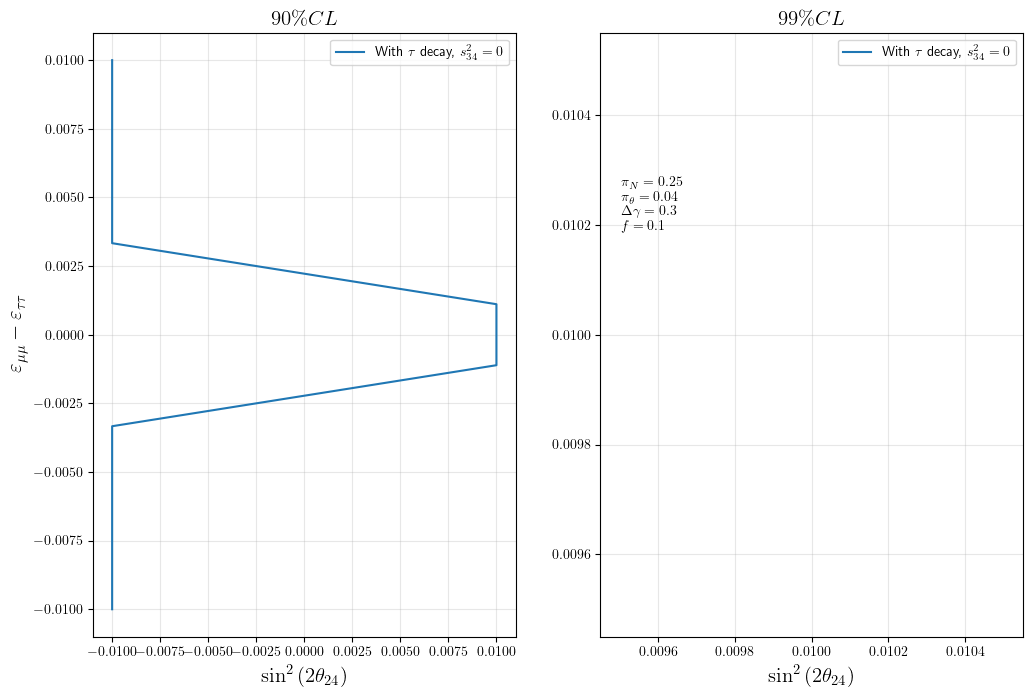

In [42]:
fig,ax = plt.subplots(1,2,figsize=(12,8))


ax[0].plot(emt_cl90, emm_cl90, label=r'With $\tau$ decay, $s_{34}^2=0$ ')


ax[1].plot(emt_cl99, emt_cl99, label=r'With $\tau$ decay, $s_{34}^2=0$ ')


#ax[0].set_xlim((s24_range.min(), s24_range.max()))
#ax[1].set_xlim((s24_range.min(), s24_range.max()))
#ax[0].set_ylim((emm_range.min(),emm_range.max()))
#ax[1].set_ylim((emm_range.min(),emm_range.max()))
ax[0].set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=15)
ax[1].set_xlabel(r'\varepsilon_{\mu\tau}$', fontsize=15)
ax[0].set_ylabel(r'$\varepsilon_{\mu\mu} - \varepsilon_{\tau\tau}$', fontsize=15)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title(r'$90\% CL$', fontsize=15)
ax[1].set_title(r'$99\% CL$', fontsize=15)

ax[0].legend()
ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')
#plt.plot(best_fit_coords[0], best_fit_coords[1], marker='o', color='black')

In [24]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
ic_params_nsi['dm_41'] = 0.93
plot_params = list_of_params_nsi(ic_params_nsi, emm_range= np.array([-0.1,0,0.1]), s24_range=np.array([0.1]))
Pam = P_over_E_parameter('m', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith = -1, ndim = 4, anti=True, nsi=True)
Pm = P_over_E_parameter('m', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith =-1, ndim = 4, anti=False, nsi=True)
Pe = P_over_E_parameter('e', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith = -1, ndim = 4, anti=False, nsi=True)
Pae = P_over_E_parameter('e', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith = -1, ndim = 4, anti=True, nsi=True)

Pamam = Pam[:,1]
Pamat = Pam[:,2]
Pmm = Pm[:,1]
Pmt = Pm[:,2]
Pem = Pe[:,1]
Paeam = Pae[:,1]

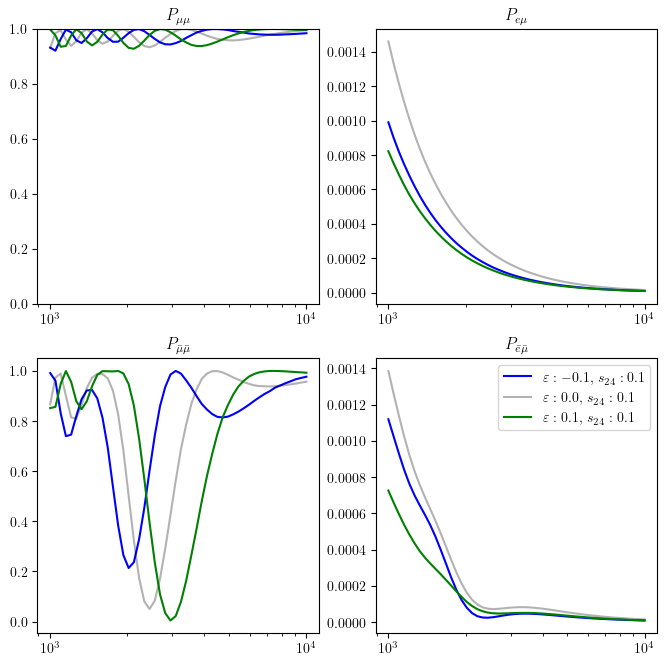

In [25]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.flatten()
colors = ['blue','black','green']
alpha = [1,0.3,1]
for i,prob in enumerate(Pmm):
    ax[0].plot(np.logspace(3,4,50), prob, c=colors[i], alpha=alpha[i],label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

for i,prob in enumerate(Pmt):
    ax[1].plot(np.logspace(3,4,50), prob, c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamam):
    ax[2].plot(np.logspace(3,4,50), prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamat):
    ax[3].plot(np.logspace(3,4,50), prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].set_ylim((0,1))
ax[0].set_title('$P_{\mu\mu}$')
ax[1].set_title('$P_{e\mu}$')
ax[2].set_title('$P_{\\bar{\mu}\\bar{\mu}}$')
ax[3].set_title('$P_{\\bar{e}\\bar{\mu}}$')
plt.legend()